In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customers_df = pd.read_csv('Data/customers.csv', low_memory=False)
leads_df = pd.read_csv('Data/leads.csv', low_memory=False)

In [3]:
customers_df['score'] = 1
leads_df['score'] = 0

In [4]:
df = pd.concat([customers_df, leads_df], ignore_index=True)

In [5]:
for feature in ['business_address_city', 'business_address_state', 'business_type', 'industry_type']:
    df[feature] = df[feature].fillna('missing')

In [6]:
df['number_of_vehicles'] = df['number_of_vehicles'].fillna(-1)
df['weekly_earnings'] = df['weekly_earnings'].fillna(-1)

In [7]:
label_encoders = {}
for feature in ['business_address_city', 'business_address_state', 'business_type', 'industry_type']:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature].astype(str))
    label_encoders[feature] = le

In [8]:
features = ['business_address_city', 'business_address_state', 'number_of_vehicles', 'weekly_earnings', 'business_type', 'industry_type']

X = df[features]
y = df['score']

In [9]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=42)

In [11]:
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [12]:
model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: np.float64(1.0004195304829064),
                                     1: np.float64(0.9995808212336342)},
                       random_state=42)

In [13]:
y_pred = model.predict(X_test)

In [14]:
report = classification_report(y_test, y_pred, target_names=['Lead', 'Customer'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

,precision,recall,f1-score,support
Lead,0.810966,0.917728,0.861050,31250.000000
Customer,0.904427,0.784459,0.840182,31015.000000
accuracy,0.851345,0.851345,0.851345,0.851345
macro avg,0.857697,0.851094,0.850616,62265.000000
weighted avg,0.857520,0.851345,0.850656,62265.000000


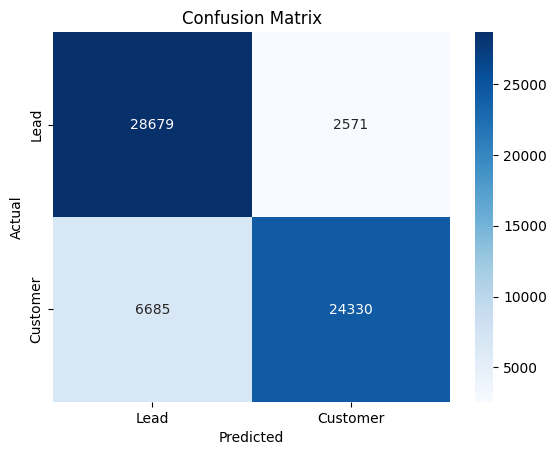

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Lead', 'Customer'], yticklabels=['Lead', 'Customer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

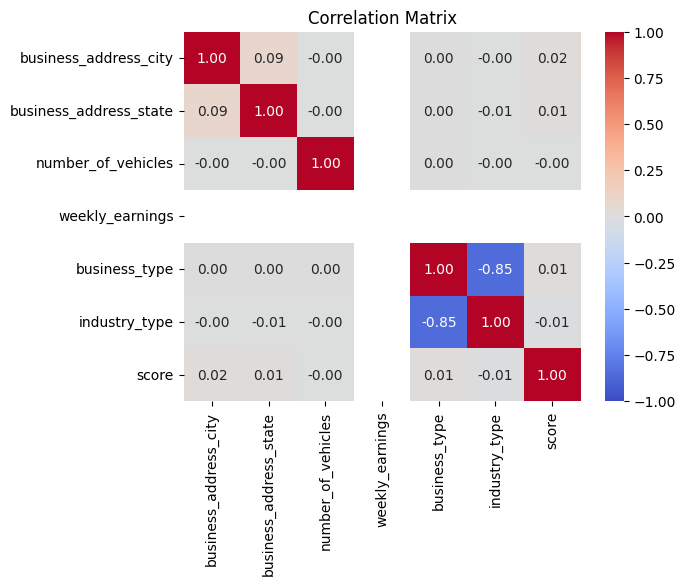

In [16]:
df_corr = df[features + ['score']].copy()
correlation_matrix = df_corr.corr()

plt.figure()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [17]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

display(feature_importance_df)

,Feature,Importance
0,business_address_city,0.462639
2,number_of_vehicles,0.401486
1,business_address_state,0.132881
4,business_type,0.001725
5,industry_type,0.001269
3,weekly_earnings,0.000000
